In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')#忽略一些警告
#显示所有结果
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 导入数据

In [3]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
train.head()

,时间,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,房屋朝向,居住状态,卧室数量,厅的数量,卫的数量,出租方式,区,位置,地铁线路,地铁站点,距离,装修情况,月租金
0,1,3072,0.128906,2,0.236364,0.008628,东南,NaN,1,1,1,NaN,11.0,118.0,2.0,40.0,0.764167,NaN,5.602716
1,1,3152,0.132812,1,0.381818,0.017046,东,NaN,1,0,0,NaN,10.0,100.0,4.0,58.0,0.709167,NaN,16.977929
2,1,5575,0.042969,0,0.290909,0.010593,东南,NaN,2,1,2,NaN,12.0,130.0,5.0,37.0,0.572500,NaN,8.998302
3,1,3103,0.085938,2,0.581818,0.019199,南,NaN,3,2,2,NaN,7.0,90.0,2.0,63.0,0.658333,NaN,5.602716
4,1,5182,0.214844,0,0.545455,0.010427,东北,NaN,2,1,1,NaN,3.0,31.0,NaN,NaN,NaN,NaN,7.300509


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196539 entries, 0 to 196538
Data columns (total 19 columns):
时间          196539 non-null int64
小区名         196539 non-null int64
小区房屋出租数量    195538 non-null float64
楼层          196539 non-null int64
总楼层         196539 non-null float64
房屋面积        196539 non-null float64
房屋朝向        196539 non-null object
居住状态        20138 non-null float64
卧室数量        196539 non-null int64
厅的数量        196539 non-null int64
卫的数量        196539 non-null int64
出租方式        24230 non-null float64
区           196508 non-null float64
位置          196508 non-null float64
地铁线路        91778 non-null float64
地铁站点        91778 non-null float64
距离          91778 non-null float64
装修情况        18492 non-null float64
月租金         196539 non-null float64
dtypes: float64(12), int64(6), object(1)
memory usage: 28.5+ MB


In [5]:
train["出租方式"].value_counts()


1.0    21814
0.0     2416
Name: 出租方式, dtype: int64

In [6]:
train["装修情况"].value_counts()


2.0    9265
6.0    7293
1.0    1154
4.0     542
3.0     214
5.0      24
Name: 装修情况, dtype: int64

In [7]:
train["居住状态"].value_counts()

3.0    17087
1.0     2483
2.0      568
Name: 居住状态, dtype: int64

In [8]:
train.drop_duplicates(['小区名','地铁线路'])[['小区名','地铁线路']].sort_values(by='小区名')

,小区名,地铁线路
107337,0,3.0
3620,1,3.0
41286,2,5.0
8211,4,NaN
55962,5,NaN
...,...,...
45347,6625,NaN
6622,6626,5.0
1513,6626,1.0
1727,6627,NaN


## 设置后面要用的填充值

In [18]:
distance_value_for_fill = 2
line_value_for_fill = 0
station_value_for_fill = 0
state_value_for_fill = 0
decoration_value_for_fill = -1
rent_value_for_fill = -1

## 缺失值处理

In [27]:
# 计算缺失值比例
def ratio_of_null():
    train_missing=(train.isnull().sum()/len(train))*100
    train_missing = train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False)
    return pd.DataFrame({'缺失值百分比':train_missing})
ratio_of_null()

,缺失值百分比
装修情况,90.591180
居住状态,89.753688
出租方式,87.671658
距离,53.302907
地铁站点,53.302907
地铁线路,53.302907
小区房屋出租数量,0.509314
位置,0.015773
区,0.015773


### 填充区和位置
根据数据初步分析时的情况可以看出，位置缺失的就是3269这个小区的，所以选择全部丢弃

In [28]:
train = train[train['小区名']!=3269]

In [29]:
ratio_of_null()

,缺失值百分比
装修情况,90.591732
居住状态,89.754107
出租方式,87.673275
距离,53.303682
地铁站点,53.303682
地铁线路,53.303682
小区房屋出租数量,0.508885


### 地铁站点，距离 处理
1.先用每个同名小区名和同位置的地铁线路,地铁站点,距离众数来填充

2.剩下的地铁站点，距离，地铁线路的缺失值作为一种特征，表示该房屋附近没有地铁

In [30]:
#先按照小区名和位置分组，然后获取每组的站点众数
station_by_neighbor_position = train[['小区名','位置','地铁站点','距离']].drop_duplicates().dropna().groupby(['小区名','位置'])['地铁站点','距离'].apply(lambda x:np.max(x.mode()))
station_by_neighbor_position

地铁站点        距离
小区名  位置                    
0    59.0    57.0  0.478333
1    59.0    57.0  0.563333
2    40.0    33.0  0.971667
11   24.0   103.0  0.914167
12   28.0    69.0  0.633333
...           ...       ...
6625 41.0    88.0  0.931667
6626 86.0    16.0  0.974167
     136.0   16.0  0.974167
6627 86.0    10.0  0.985000
     136.0   10.0  0.985000

[3342 rows x 2 columns]

In [31]:
station_by_neighbor=train[['小区名','地铁站点','距离']].drop_duplicates().dropna().groupby('小区名')['地铁站点','距离'].apply(lambda x:np.max(x.mode()))
station_by_neighbor

,地铁站点,距离
小区名,,
0,57.0,0.478333
1,57.0,0.563333
2,33.0,0.971667
11,103.0,0.914167
12,69.0,0.633333
...,...,...
6622,25.0,0.245000
6623,119.0,0.410000
6625,88.0,0.931667


In [32]:
# 拿到每个站点对应的线路
line_by_station=train[['地铁站点','地铁线路']].drop_duplicates().dropna().groupby('地铁站点')['地铁线路'].min()
line_by_station

地铁站点
1.0      4.0
2.0      2.0
3.0      1.0
4.0      5.0
5.0      1.0
        ... 
115.0    5.0
116.0    1.0
117.0    4.0
118.0    4.0
119.0    1.0
Name: 地铁线路, Length: 118, dtype: float64

In [35]:
def fill_stations(line,station_by_neighbor_position,station_by_neighbor,line_by_station):
    if not pd.isna(line['地铁站点']):
        return line
    if (line['小区名'],line['位置']) in station_by_neighbor_position:
        line['地铁站点']=station_by_neighbor_position.loc[(line['小区名'],line['位置']),'地铁站点']
        line['距离']=station_by_neighbor_position.loc[(line['小区名'],line['位置']),'距离']
        line['地铁线路']=line_by_station[line['地铁站点']]
    elif line['小区名'] in station_by_neighbor.index:
        line['地铁站点'] = station_by_neighbor.loc[line['小区名'],'地铁站点']
        line['距离'] = station_by_neighbor.loc[line['小区名'],'距离']
        line['地铁线路'] = line_by_station[line['地铁站点']]
    else:
        line['地铁站点']=station_value_for_fill
        line['距离'] = distance_value_for_fill
        line['地铁线路'] = line_value_for_fill
    return line

train = train.apply(fill_stations,station_by_neighbor_position=station_by_neighbor_position,station_by_neighbor=station_by_neighbor,line_by_station=line_by_station,axis=1)
ratio_of_null()

,缺失值百分比
装修情况,90.591732
居住状态,89.754107
出租方式,87.673275
小区房屋出租数量,0.508885


## 小区房屋出租数量处理
用每个小区的房屋出租数量众数填充

In [36]:
#拿到每个小区房屋出租数量的众数
ratio_by_neighbor=train[['小区名','小区房屋出租数量']].dropna().groupby('小区名').apply(lambda x:np.mean(x["小区房屋出租数量"].mode()))
ratio_by_neighbor

小区名
0       0.007812
1       0.011719
2       0.007812
4       0.017578
5       0.009766
          ...   
6623    0.011719
6624    0.013672
6625    0.011719
6626    0.076172
6627    0.093750
Length: 5535, dtype: float64

In [37]:
#拿到所有小区的“小区房屋出租数量”众数
ratio_mode=train["小区房屋出租数量"].mode().values[0]
ratio_mode

0.01953125

In [38]:
def fill_rent_num(x,k,v,values,mode):
    if not pd.isna(x[v]):
        return x
    else:
        if x[k] in values.index:
            x[v] = values[x[k]]
        else:
            x[v]=mode
        return x

train=train.apply(fill_rent_num,k='小区名',v='小区房屋出租数量',values=ratio_by_neighbor,mode=ratio_mode,axis=1)
ratio_of_null()

,缺失值百分比
装修情况,90.591732
居住状态,89.754107
出租方式,87.673275


## 装修，居住状态，出租方式直接填充

In [39]:
train['出租方式']=train['出租方式'].fillna(rent_value_for_fill)
train['装修情况']=train['装修情况'].fillna(decoration_value_for_fill)
train['居住状态']=train['居住状态'].fillna(state_value_for_fill)
ratio_of_null()

,缺失值百分比


## 清除异常样本

In [40]:
# 去掉房屋面积存在的异常值
train=train[train['房屋面积']<0.3]
train.shape

(196499, 19)

## 处理月租金
针对目标值月租金普遍分布过散，进行对数平滑

In [41]:
train['log_rent']=np.log1p(train['月租金'])  # np.log1p  log(1+x)   inf

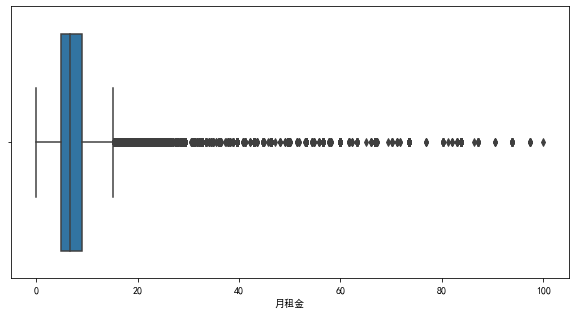

In [42]:
# 纠正之前
plt.figure(figsize=(10,5))
sns.boxplot(x='月租金',data=train,orient='h')
plt.show()

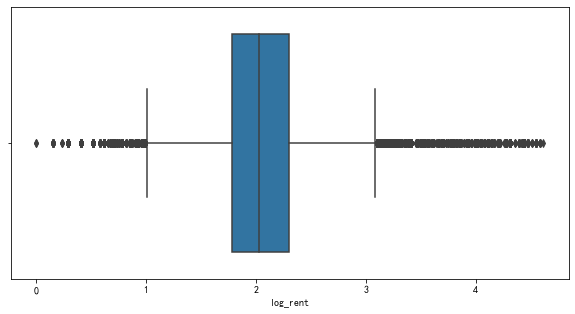

In [43]:
# 纠偏之后
plt.figure(figsize=(10,5))
sns.boxplot(x="log_rent",data=train,orient='h')
plt.show()

In [44]:
train.head()

,时间,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,房屋朝向,居住状态,卧室数量,厅的数量,卫的数量,出租方式,区,位置,地铁线路,地铁站点,距离,装修情况,月租金,log_rent
0,1,3072,0.128906,2,0.236364,0.008628,东南,0.0,1,1,1,-1.0,11.0,118.0,2.0,40.0,0.764167,-1.0,5.602716,1.887481
1,1,3152,0.132812,1,0.381818,0.017046,东,0.0,1,0,0,-1.0,10.0,100.0,4.0,58.0,0.709167,-1.0,16.977929,2.889145
2,1,5575,0.042969,0,0.290909,0.010593,东南,0.0,2,1,2,-1.0,12.0,130.0,5.0,37.0,0.572500,-1.0,8.998302,2.302415
3,1,3103,0.085938,2,0.581818,0.019199,南,0.0,3,2,2,-1.0,7.0,90.0,2.0,63.0,0.658333,-1.0,5.602716,1.887481
4,1,5182,0.214844,0,0.545455,0.010427,东北,0.0,2,1,1,-1.0,3.0,31.0,0.0,0.0,2.000000,-1.0,7.300509,2.116317


## 问题数据处理
房屋朝向列有多个值,取第一个

In [45]:
def split(text,i):
    items = text.split(' ')
    if i<len(items):
        return items[i]
    else:
        return np.nan

train['新朝向']=train['房屋朝向'].map(lambda x:split(x,0))        

In [46]:
train.head()

,时间,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,房屋朝向,居住状态,卧室数量,厅的数量,...,出租方式,区,位置,地铁线路,地铁站点,距离,装修情况,月租金,log_rent,新朝向
0,1,3072,0.128906,2,0.236364,0.008628,东南,0.0,1,1,...,-1.0,11.0,118.0,2.0,40.0,0.764167,-1.0,5.602716,1.887481,东南
1,1,3152,0.132812,1,0.381818,0.017046,东,0.0,1,0,...,-1.0,10.0,100.0,4.0,58.0,0.709167,-1.0,16.977929,2.889145,东
2,1,5575,0.042969,0,0.290909,0.010593,东南,0.0,2,1,...,-1.0,12.0,130.0,5.0,37.0,0.572500,-1.0,8.998302,2.302415,东南
3,1,3103,0.085938,2,0.581818,0.019199,南,0.0,3,2,...,-1.0,7.0,90.0,2.0,63.0,0.658333,-1.0,5.602716,1.887481,南
4,1,5182,0.214844,0,0.545455,0.010427,东北,0.0,2,1,...,-1.0,3.0,31.0,0.0,0.0,2.000000,-1.0,7.300509,2.116317,东北


In [49]:
train['新朝向'].value_counts()

南     59605
东南    55854
东     34282
西南    17750
北     10490
西      9972
西北     5259
东北     3287
Name: 新朝向, dtype: int64

## 保存数据

In [50]:
train.to_csv('data/train_etl.csv',index=None)